In [5]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import kagglehub

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
# Download latest version
path = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")

print("Path to dataset files:", path)

Path to dataset files: /Users/finnschonknecht/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1


In [1]:
dataset_path = "/Users/finnschonknecht/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1"

In [9]:
all_folder_path = os.path.join(dataset_path, 'ALL')

In [11]:
dir_list = os.listdir(all_folder_path + "/")

# Initialize lists
emotion = []
path = []

# Path to the ALL folder
base_path = "/Users/finnschonknecht/.cache/kagglehub/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/"

for i in dir_list:
    # Append emotion based on the file name
    if i[-8:-6] == '_a':
        emotion.append('male_angry')
    elif i[-8:-6] == '_d':
        emotion.append('male_disgust')
    elif i[-8:-6] == '_f':
        emotion.append('male_fear')
    elif i[-8:-6] == '_h':
        emotion.append('male_happy')
    elif i[-8:-6] == '_n':
        emotion.append('male_neutral')
    elif i[-8:-6] == 'sa':
        emotion.append('male_sad')
    elif i[-8:-6] == 'su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    
    # Append the full path to the file
    path.append(os.path.join(base_path, i))

# Now check out the label count distribution 
SAVEE_df = pd.DataFrame({'labels': emotion, 'file_path': path})

print(SAVEE_df.head())

          labels                                          file_path
0       male_sad  /Users/finnschonknecht/.cache/kagglehub/datase...
1       male_sad  /Users/finnschonknecht/.cache/kagglehub/datase...
2   male_neutral  /Users/finnschonknecht/.cache/kagglehub/datase...
3  male_surprise  /Users/finnschonknecht/.cache/kagglehub/datase...
4   male_neutral  /Users/finnschonknecht/.cache/kagglehub/datase...


In [8]:
SAVEE_df

,labels,file_path
0,male_sad,/Users/finnschonknecht/.cache/kagglehub/datase...
1,male_sad,/Users/finnschonknecht/.cache/kagglehub/datase...
2,male_neutral,/Users/finnschonknecht/.cache/kagglehub/datase...
3,male_surprise,/Users/finnschonknecht/.cache/kagglehub/datase...
4,male_neutral,/Users/finnschonknecht/.cache/kagglehub/datase...
...,...,...
475,male_angry,/Users/finnschonknecht/.cache/kagglehub/datase...
476,male_angry,/Users/finnschonknecht/.cache/kagglehub/datase...
477,male_neutral,/Users/finnschonknecht/.cache/kagglehub/datase...
478,male_surprise,/Users/finnschonknecht/.cache/kagglehub/datase...


In [10]:
SAVEE_df.labels.value_counts()

labels
male_neutral     120
male_sad          60
male_surprise     60
male_fear         60
male_disgust      60
male_happy        60
male_angry        60
Name: count, dtype: int64

## Fear Audio

In [12]:
def waveplot(data, sampling_r, emotion):
    plt.figure(figsize=(10,5))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sampling_r)
    plt.show()

def spectogram_plot(data, sampling_r, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sampling_r, x_axis='time', y_axis='hz')
    plt.colorbar()

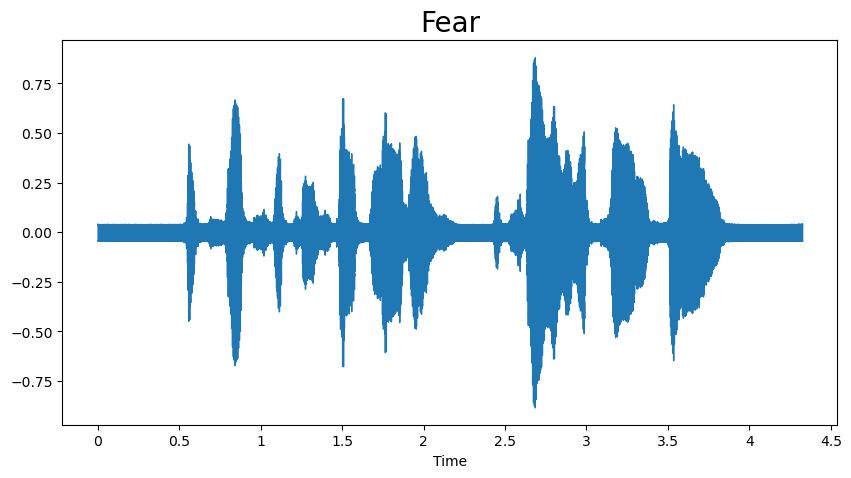

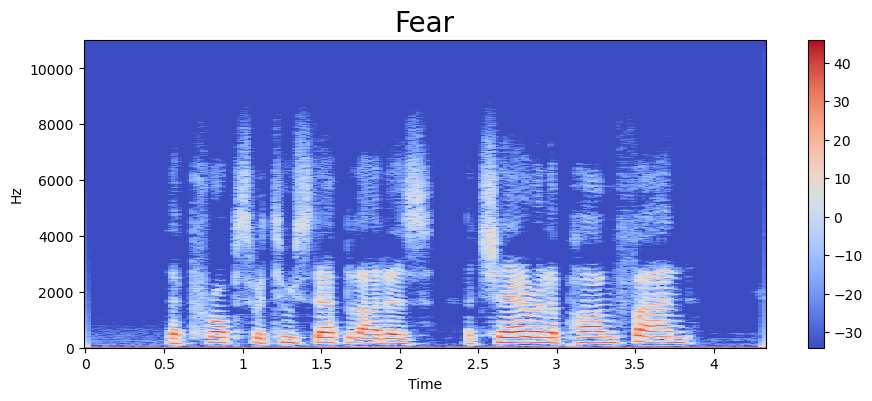

In [13]:
fname = base_path + 'DC_f11.wav'  
data, sampling_rate = librosa.load(fname)
waveplot(data, sampling_r=sampling_rate, emotion="Fear")
spectogram_plot(data, sampling_r = sampling_rate, emotion = "Fear")
ipd.Audio(fname)

## Happy Audio

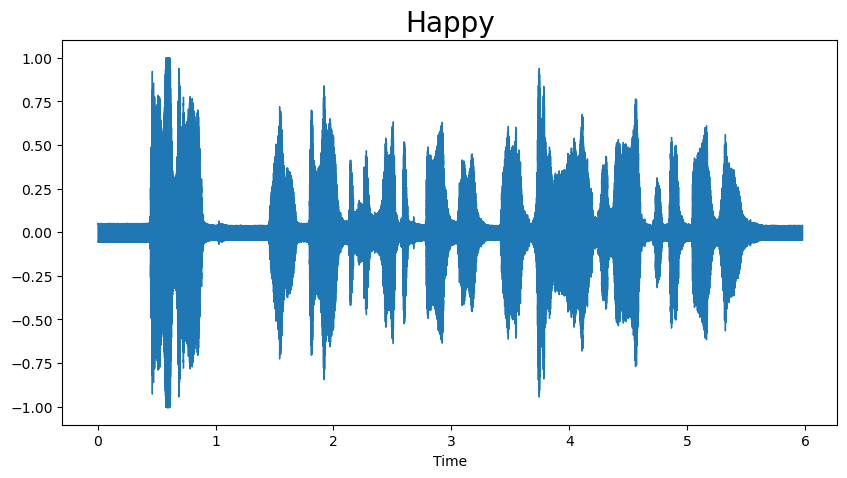

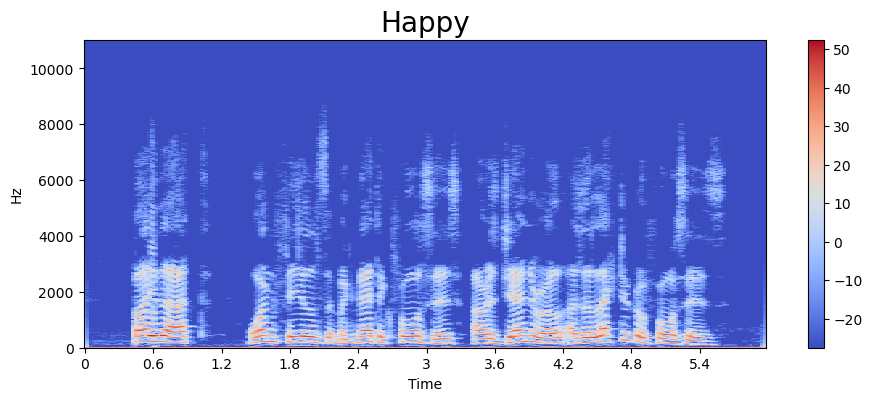

In [24]:
fname = base_path + 'DC_h11.wav'  
data, sampling_rate = librosa.load(fname)
waveplot(data, sampling_r=sampling_rate, emotion="Happy")
spectogram_plot(data, sampling_r = sampling_rate, emotion = "Happy")
ipd.Audio(fname)

## Angry

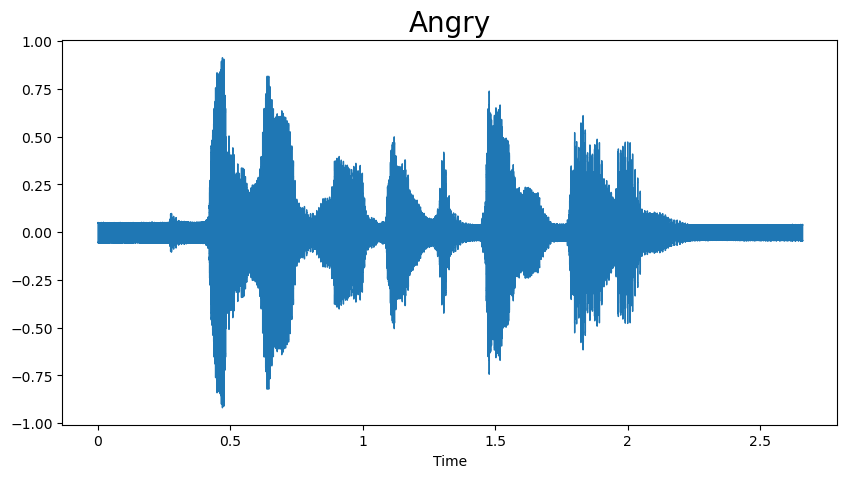

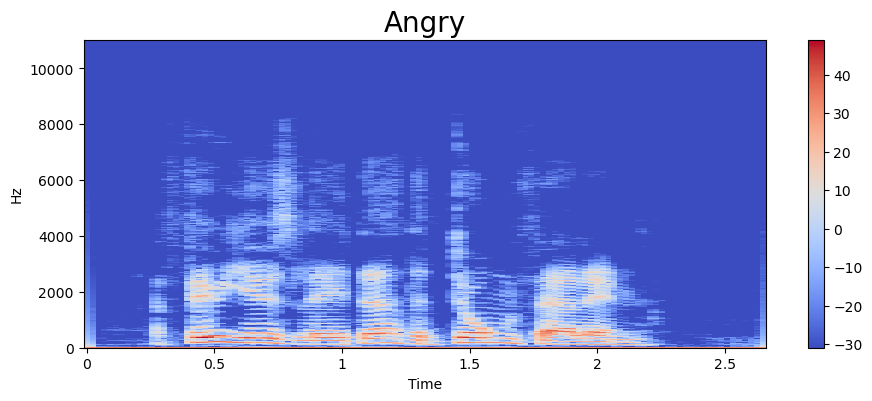

In [26]:
fname = base_path + 'DC_a11.wav'  
data, sampling_rate = librosa.load(fname)
waveplot(data, sampling_r=sampling_rate, emotion="Angry")
spectogram_plot(data, sampling_r = sampling_rate, emotion = "Angry")
ipd.Audio(fname)

## Feature Extraction

In [31]:
def mfcc(filename):
    y, sr = librosa.load(filename, duration=5, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    return mfcc

In [20]:
def extract_features_from_file(file_path, n_mfcc=13):
    try:
        # Load the audio file
        audio, sr = librosa.load(file_path, sr=None)

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc.T, axis=0)  # Take the mean over time

        # Extract Chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        chroma_mean = np.mean(chroma.T, axis=0)  # Take the mean over time

        # Combine MFCC and Chroma features
        features = np.concatenate((mfcc_mean, chroma_mean))
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Process dataset
def process_audio_dataset(df, feature_column="file_path", label_column="labels", n_mfcc=13):
    features_list = []
    labels_list = []

    for index, row in df.iterrows():
        file_path = row[feature_column]
        label = row[label_column]
        
        # Extract features for the audio file
        features = extract_features_from_file(file_path, n_mfcc=n_mfcc)
        if features is not None:
            features_list.append(features)
            labels_list.append(label)

    # Combine features and labels into a DataFrame
    features_df = pd.DataFrame(features_list)
    features_df['label'] = labels_list
    return features_df

# Example usage
if __name__ == "__main__":
    # Assuming your dataset is saved as a CSV file
    dataset_path = "/path/to/your/dataset.csv"
    df = SAVEE_df

    # Process the dataset
    processed_df = process_audio_dataset(df)
    print("Processed dataset shape:", processed_df.shape)

Processed dataset shape: (480, 26)


## SMOTE

• Here we are using smote to even the class distribution and to give our models more training data <br>
• it is important to seperate the training and testing data first to ensure there is no data leakage when evaluating the model

In [16]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [26]:
X = processed_df.drop(columns=['label'])
y = processed_df['label'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 1: Separate features and labels
def apply_smote(X_train, y_train, label_column='label'):
  
    # Step 2: Encode labels into numeric values
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)  # Encode labels (e.g., male_sad -> 0)

    # Step 3: Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

    # Step 4: Decode labels back to original form
    y_train_resampled_decoded = le.inverse_transform(y_train_resampled)

    # Step 5: Combine resampled features and labels into a DataFrame
    resampled_train_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)
    resampled_train_df[label_column] = y_train_resampled_decoded
    return resampled_train_df

# Example usage
if __name__ == "__main__":
    balanced_train_df = apply_smote(X_train, y_train)
    print("Balanced dataset shape:", balanced_train_df.shape)
    print("Class distribution after SMOTE:")
    print(balanced_train_df['label'].value_counts())

Balanced dataset shape: (679, 26)
Class distribution after SMOTE:
label
male_angry       97
male_neutral     97
male_sad         97
male_happy       97
male_disgust     97
male_surprise    97
male_fear        97
Name: count, dtype: int64


In [28]:
balanced_train_labels = balanced_train_df['label']
balanced_train_df = balanced_train_df.drop(columns=['label'])

## Random Forest model

In [30]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(balanced_train_df, balanced_train_labels)

# Evaluate the model
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

   male_angry       0.64      0.88      0.74         8
 male_disgust       0.45      0.42      0.43        12
    male_fear       0.55      0.60      0.57        10
   male_happy       0.64      0.50      0.56        14
 male_neutral       0.61      0.87      0.71        23
     male_sad       0.83      0.53      0.65        19
male_surprise       0.43      0.30      0.35        10

     accuracy                           0.60        96
    macro avg       0.59      0.58      0.57        96
 weighted avg       0.61      0.60      0.59        96



In [69]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=clf.classes_)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 7  1  0  0  0  0  0]
 [ 0  5  1  1  4  0  1]
 [ 0  1  6  0  2  0  1]
 [ 3  0  2  7  0  0  2]
 [ 0  1  0  0 20  2  0]
 [ 0  2  0  0  7 10  0]
 [ 1  1  2  3  0  0  3]]


## LSTM Model

In [42]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.regularizers import l2

In [46]:
X_train_resampled = balanced_train_df.values  # or balanced_train_df.to_numpy()

# Example data shape: (n_samples, n_features)
n_samples = X_train_resampled.shape[0]
n_features = X_train_resampled.shape[1]

# Define your time steps (sequence length) per sample.
time_steps = min(50, n_features)  # Adjust based on your needs

# Check if features can be divided by time_steps
if n_features < time_steps:
    raise ValueError("The number of features must be greater than or equal to the number of time steps.")

# Calculate the number of features per time step
features_per_time_step = n_features // time_steps

# Check if the calculated features_per_time_step is greater than 0
if features_per_time_step == 0:
    raise ValueError(f"Cannot have features per time step = 0. Adjust time_steps or features.")

# Reshape your data into 3D: (n_samples, time_steps, features_per_time_step)
X_train_reshaped = X_train_resampled.reshape((n_samples, time_steps, features_per_time_step))

# Print the new shape to verify
print("Reshaped X_train shape:", X_train_reshaped.shape)

Reshaped X_train shape: (679, 25, 1)


In [48]:
# Convert DataFrame to NumPy array

X_test_resampled = X_test.values  # or balanced_train_df.to_numpy()

# Example data shape: (n_samples, n_features)
n_samples = X_test_resampled.shape[0]
n_features = X_test_resampled.shape[1]

# Define your time steps (sequence length) per sample.
time_steps = min(50, n_features)  # Adjust based on your needs

# Check if features can be divided by time_steps
if n_features < time_steps:
    raise ValueError("The number of features must be greater than or equal to the number of time steps.")

# Calculate the number of features per time step
features_per_time_step = n_features // time_steps

# Check if the calculated features_per_time_step is greater than 0
if features_per_time_step == 0:
    raise ValueError(f"Cannot have features per time step = 0. Adjust time_steps or features.")

# Reshape your data into 3D: (n_samples, time_steps, features_per_time_step)
X_test_reshaped = X_test_resampled.reshape((n_samples, time_steps, features_per_time_step))

# Print the new shape to verify
print("Reshaped X_test shape:", X_test_reshaped.shape)

Reshaped X_test shape: (96, 25, 1)


In [50]:
X_train_padded = pad_sequences(X_train_reshaped, padding='post', dtype='float32')
X_test_padded = pad_sequences(X_test_reshaped, padding='post', dtype='float32')

In [52]:
# Encode the labels numerically
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(balanced_train_labels)
y_val_encoded = label_encoder.transform(y_test)

# If needed, one-hot encode labels for multi-class classification
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train_encoded)
y_val_one_hot = to_categorical(y_val_encoded)

In [54]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(7, activation='softmax')

])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], )
model.summary()

/Users/finnschonknecht/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,799 (1.17 MB)

 Trainable params: 305,799 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
history = model.fit(X_train_padded, y_train_one_hot, epochs=50, batch_size=8, validation_data=(X_test_padded, y_val_one_hot))

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.1660 - loss: 2.1261 - val_accuracy: 0.2812 - val_loss: 1.9893
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2170 - loss: 1.9140 - val_accuracy: 0.2500 - val_loss: 1.7684
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2794 - loss: 1.7800 - val_accuracy: 0.3021 - val_loss: 1.6778
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2704 - loss: 1.7301 - val_accuracy: 0.2396 - val_loss: 1.6537
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2605 - loss: 1.7156 - val_accuracy: 0.3750 - val_loss: 1.5939
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2921 - loss: 1.6497 - val_accuracy: 0.3333 - val_loss: 1.7090
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2830 - loss: 1.6451 - val_accuracy: 0.3021 - val_loss: 1.5811
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2844 - loss: 1.6027 - val_accuracy: 0.2917 - v

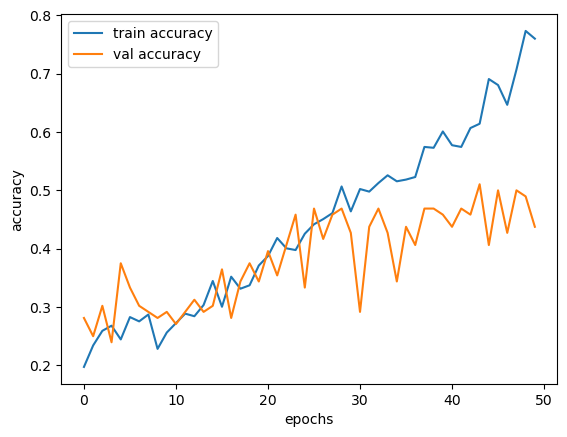

In [60]:
epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

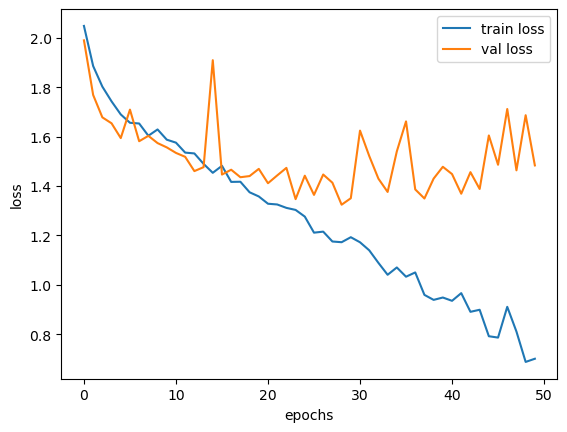

In [62]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

• We can see the LSTM model struggles with improving accuracy on the validation data, this could be due to the limited size of the dataset or the model is overfitting on the training data. Dropouts and regularisers were added to try account for this but they did not seem to aid in model performance